# Title I Allocations w/ DP ACS

## Algorithm

### Data
Need state per-pupil expenditure (SPPE) from the NCES. Most recent I can find in <5min is the [FY '18 data](https://nces.ed.gov/pubsearch/pubsinfo.asp?pubid=2020308).

Had to use an online tool to convert Table 2 of [this report](https://nces.ed.gov/pubs2020/2020308.pdf).

In [1]:
import pandas as pd

def get_sppe(path):
    states = { 'Alabama': 'AL', 'Alaska': 'AK', 'American Samoa': 'AS', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'District of Columbia': 'DC', 'Florida': 'FL', 'Georgia': 'GA', 'Guam': 'GU', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Northern Mariana Islands':'MP', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Puerto Rico': 'PR', 'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virgin Islands': 'VI', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY' }
    states = pd.DataFrame(states.items(), columns=["state", "abbrv"])
    
    # quirk of original data file - need to change DC's name for join
    states[states.state == "District of Columbia"] = "District Of Columbia Public Schools"

    sppe = pd.read_excel(path, header=2).rename(columns={"Unnamed: 0": "state"})[["state", "ppe"]]

    return sppe.merge(states, on="state", how="right")

sppe = get_sppe("../data/sppe18.xlsx")
sppe.head()

,state,ppe,abbrv
0,Alabama,9697,AL
1,Alaska,17726,AK
2,American Samoa,NaN,AS
3,Arizona,8296,AZ
4,Arkansas,10072,AR


Also need a dict matching district IDs to district names to states. Simplest to use [SAIPE 2019](https://www2.census.gov/programs-surveys/saipe/datasets/2019/2019-school-districts/) ground-truth.

In [2]:
saipe = pd.read_excel("../data/saipe19.xls", header=2).set_index("District ID")
saipe.head()

,State Postal Code,State FIPS Code,Name,Estimated Total Population,Estimated Population 5-17,Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder
District ID,,,,,,
190,AL,1,Alabaster City School District,34669,6710,649
5,AL,1,Albertville City School District,22051,4131,957
30,AL,1,Alexander City City School District,16920,2575,703
60,AL,1,Andalusia City School District,8842,1465,406
90,AL,1,Anniston City School District,22043,3065,1057


Also, a method for roughly estimating standard errors for the SAIPE estimates, based on [these published docs](https://www.census.gov/programs-surveys/saipe/guidance/district-estimates.html). This could be improved - but start with this as a shortcut.

In [3]:
def median_cv(total_pop):
    # based on the table given here https://www.census.gov/programs-surveys/saipe/guidance/district-estimates.html
    if total_pop <= 2500:
        return 0.67
    elif total_pop <= 5000:
        return 0.42
    elif total_pop <= 10000:
        return 0.35
    elif total_pop <= 20000:
        return 0.28
    elif total_pop <= 65000:
        return 0.23
    return 0.15

saipe["median_cv"] = saipe.apply(lambda x: median_cv(x["Estimated Total Population"]), axis=1)
saipe.head()

,State Postal Code,State FIPS Code,Name,Estimated Total Population,Estimated Population 5-17,Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder,median_cv
District ID,,,,,,,
190,AL,1,Alabaster City School District,34669,6710,649,0.23
5,AL,1,Albertville City School District,22051,4131,957,0.23
30,AL,1,Alexander City City School District,16920,2575,703,0.28
60,AL,1,Andalusia City School District,8842,1465,406,0.35
90,AL,1,Anniston City School District,22043,3065,1057,0.23


### Code

First, a class for the different privacy mechanisms we might employ to compute poverty estimates.

In [4]:
from typing import Tuple

class Mechanism:
    def __init__(self, epsilon, delta):
        self.epsilon = epsilon
        self.delta = delta
        
    def poverty_estimates(self) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """
        Returns dataframe for children in poverty, children total, and total population indexed by district ID.
        """
        raise NotImplementedError
        
class GroundTruth(Mechanism):
    """
    example mech that just returns the ground truth SAIPE estimates
    """
    def __init__(self, saipe):
        self.saipe = saipe
        
    def poverty_estimates(self):
        return (self.saipe[key] for key in ["Estimated Total Population", "Estimated Population 5-17", "Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder"])

Next, a class for the different ways we might allocate funds based on the poverty estimates (e.g. Abowd's shortcut method vs. the full Sonnenberg method).

In [5]:
from math import floor, ceil

class Allocator:
    def __init__(self, estimates, congress_cap=0.4, adj_sppe_bounds=[0.32, 0.48], adj_sppe_bounds_efig=[0.34, 0.46]):
        self.estimates = estimates
        self.congress_cap = congress_cap
        self.adj_sppe_bounds = adj_sppe_bounds
        self.adj_sppe_bounds_efig = adj_sppe_bounds_efig
    
    def allocations(self) -> pd.DataFrame:
        self.calc_alloc()
        return self.estimates
        
    def calc_alloc(self):
        """
        Appends the allocated grants as columns to the estimates DataFrame.
        """
        raise NotImplementedError
        
    def adj_sppe(self):
        avg_sppe = np.mean(self.estimates.sppe)
        adj_sppe = self.estimates.sppe * self.congress_cap
        adj_sppe_trunc = adj_sppe.clip(*np.array(self.adj_sppe_bounds)*avg_sppe)
        adj_sppe_efig = adj_sppe.clip(*np.array(self.adj_sppe_bounds_efig)*avg_sppe)
        
        return adj_sppe_trunc, adj_sppe_efig

class AbowdAllocator(Allocator):
    """
    As described in https://arxiv.org/pdf/1808.06303.pdf
    """
    def calc_alloc(self):
        adj_sppe, _ = self.adj_sppe()
        
        self.estimates["adj_sppe"] = adj_sppe
        self.estimates["true_allocation"] = adj_sppe * self.estimates.true_children_eligible
        self.estimates["est_allocation"] = adj_sppe * self.estimates.est_children_eligible

def weighting(eligible, pop):
    """
    Gradated weighting algorithm given in [Sonnenberg](https://nces.ed.gov/surveys/annualreports/pdf/titlei20160111.pdf).
    
    Returns weighted eligibility counts.
    """
    
    # calculate weighted count based on counts
    wec_counts = 0
    for r, w in {(1, 691): 1.0, (692, 2262): 1.5, (2263,7851): 2.0, (7852, 35514): 2.5, (35514, None): 3.0}.items():
        if r[1] is not None and eligible > r[1]: 
            wec_counts += (r[1] - r[0] + 1) * w
        elif eligible >= r[0]: 
            wec_counts += (eligible - r[0] + 1) * w
    
    # calculate weighted count based on proportions
    wec_props = 0
    for r, w in {(0, 0.1558): 1.0, (0.1558, 0.2211): 1.75, (0.2211,0.3016): 2.5, (0.3016, 0.3824): 3.25, (0.3824, None): 4.0}.items():
        upper = floor(r[1]*pop) if r[1] is not None else None
        lower = ceil(r[0]*pop)
        
        if upper is not None and eligible > upper: 
            wec_props += (upper - lower) * w
        elif eligible >= lower: 
            wec_props += (eligible - lower) * w
    
    # take the higher weighted eligibility count
    return max(wec_counts, wec_props)

weighting(1559, 10000)

1993.0

In [6]:
class SonnenbergAuthorizer(Allocator):
    def calc_alloc(self):
        # calc adj. SPPE
        adj_sppe, adj_sppe_efig = self.adj_sppe()
        
        # calculate grant amounts for true/randomized values
        for prefix in ("true", "est"):        

            ## BASIC GRANTS
            # authorization calculation
            self.estimates[f"{prefix}_grant_basic"] = self.estimates[f"{prefix}_children_eligible"] * adj_sppe
            # For basic grants, LEA must have >10 eligible children
            eligible = self.estimates[f"{prefix}_children_eligible"] >= 10
    #         print(sum(~eligible)/eligible.shape[0])
            self.estimates.loc[~eligible, f"{prefix}_grant_basic"] = 0.0

            ## CONCENTRATION GRANTS
            # For concentration grants, LEAs must meet basic eligibility AND have either
            # a) >6500 eligible
            # b) 15% of pop. is eligible
            self.estimates[f"{prefix}_grant_concentration"] = self.estimates[f"{prefix}_grant_basic"]
            count_eligible = self.estimates[f"{prefix}_children_eligible"] >= 6500
            prop_eligible = (self.estimates[f"{prefix}_children_eligible"] / self.estimates[f"{prefix}_children_total"]) >= 0.15
            eligible = count_eligible | prop_eligible
    #         print(sum(~eligible)/eligible.shape[0])
            self.estimates.loc[~eligible, f"{prefix}_grant_concentration"] = 0.0

            ## TARGETED GRANTS
            # weighted by an exogenous step function - see documentation
            weighted_eligible = self.estimates[[f"{prefix}_children_eligible", f"{prefix}_children_total"]].apply(
                lambda x: weighting(x[0], x[1])
            , axis=1)
            self.estimates[f"{prefix}_grant_targeted"] = weighted_eligible * adj_sppe

            # for targeted grants, LEAs must meet basic eligibility AND have >5% eligible
            count_eligible = self.estimates[f"{prefix}_children_eligible"] >= 10
            prop_eligible = (self.estimates[f"{prefix}_children_eligible"] / self.estimates[f"{prefix}_children_total"]) >= 0.05
            eligible = count_eligible & prop_eligible
            self.estimates.loc[~eligible, f"{prefix}_grant_targeted"] = 0.0

            ## EFIG
            # TODO

Finally, the main method for computing estimates, then grant amounts.

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


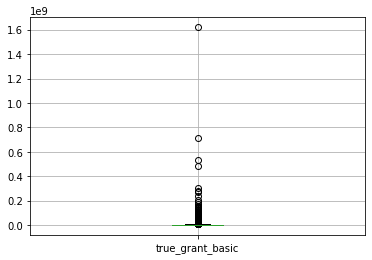

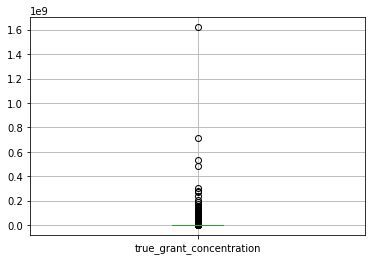

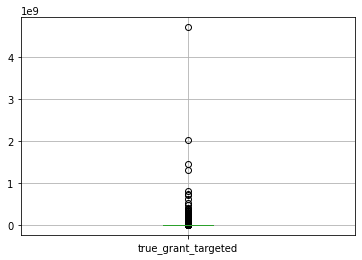

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def funding(saipe, allocator, mechanism, sppe, weighting, *mech_args, verbose=True, **mech_kwargs):
    """
    congress_cap - proportion of a student's edu congress agrees to fund
    
    Returns augmented SAIPE dataframe with randomized estimates and true/randomized grant amounts.
    """
    grants = saipe.rename(columns={
        "Estimated Total Population": "true_pop_total",
        "Estimated Population 5-17": "true_children_total",
        "Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder": "true_children_poverty"
    })
    pop_total, children_total, children_poverty = mechanism.poverty_estimates(*mech_args, **mech_kwargs)
    grants["est_pop_total"] = pop_total
    grants["est_children_total"] = children_total
    grants["est_children_poverty"] = children_poverty

    # BIG ASSUMPTION, TODO: revisit later
    grants["true_children_eligible"] = grants.true_children_poverty
    grants["est_children_eligible"] = grants.est_children_poverty
    
    # join in SPPE
    grants = grants.merge(sppe, left_on="State Postal Code", right_on="abbrv").drop(columns=['abbrv', 'state']).rename(columns={'ppe': 'sppe'})
    if verbose: print("[WARN] Dropping districts with missing SPPE data:", grants[grants.sppe.isna()]['Name'].values)
    grants = grants.dropna(subset=["sppe"])
    grants.sppe = grants.sppe.astype(float)
    
    alloc = allocator(grants)
    
    return alloc.allocations()


# Test with ground truth mechanism
grants = funding(saipe, SonnenbergAuthorizer, GroundTruth(saipe), get_sppe("../data/sppe18.xlsx"), weighting)
grants.boxplot('true_grant_basic')
plt.show()
grants.boxplot('true_grant_concentration')
plt.show()
grants.boxplot('true_grant_targeted')
plt.show()

## Laplace
### Data
From [SAIPE 2019](https://www2.census.gov/programs-surveys/saipe/datasets/2019/2019-school-districts/) release.

### Mechanism

In [8]:
from diffprivlib.mechanisms.laplace import Laplace as LaplaceMech, LaplaceTruncated

"""
Following Abowd & Schmutte (2019), return \hat{E}_l = E_l + e_l, where e_l \sim Laplace(1/\epsilon). 

Recall that the sensitivity of the counts here is simply 1.
"""

class Laplace(Mechanism):
    def __init__(self, saipe, *args, pos_trunc=False, **kwargs):
        super().__init__(*args, **kwargs)
        self.saipe = saipe
        
        self.mechanism = \
            LaplaceTruncated(epsilon=self.epsilon, delta=self.delta, sensitivity=1.0, lower=0.0) if pos_trunc \
            else LaplaceMech(epsilon=self.epsilon, delta=self.delta, sensitivity=1.0)
        
    def poverty_estimates(self) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        
        pop_total = saipe["Estimated Total Population"].apply(self.mechanism.randomise)
        children_total = saipe["Estimated Population 5-17"].apply(self.mechanism.randomise)
        children_poverty = saipe["Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder"].apply(self.mechanism.randomise)
        
        # no negative values, please
        return np.clip(pop_total, 0, None), np.clip(children_total, 0, None), np.clip(children_poverty, 0, None)
        
Laplace(saipe, 0.1, 0).poverty_estimates()

(District ID
 190     3.468103e+04
 5       2.203916e+04
 30      1.692272e+04
 60      8.834064e+03
 90      2.204835e+04
             ...     
 6240    7.136093e+03
 5820    6.989009e+02
 4830    5.462673e+03
 6090    1.466373e+03
 30      3.193719e+06
 Name: Estimated Total Population, Length: 13184, dtype: float64,
 District ID
 190       6732.675059
 5         4154.489938
 30        2584.666645
 60        1458.239239
 90        3064.628049
             ...      
 6240      1296.969481
 5820        89.241258
 4830       816.901035
 6090       235.051974
 30      455266.052543
 Name: Estimated Population 5-17, Length: 13184, dtype: float64,
 District ID
 190        642.897684
 5          937.656244
 30         716.461761
 60         429.561161
 90        1069.369109
             ...      
 6240       149.351880
 5820        19.864439
 4830        98.739561
 6090        19.071639
 30      248620.844709
 Name: Estimated number of relevant children 5 to 17 years old in poverty who are 

### Results
First, using the full Sonnenberg authorization algo.

In [32]:
grants = funding(saipe, SonnenbergAuthorizer, Laplace(saipe, 5, 0), get_sppe("../data/sppe18.xlsx"), weighting)
grants.describe()

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


,State FIPS Code,true_pop_total,true_children_total,true_children_poverty,est_pop_total,est_children_total,est_children_poverty,true_children_eligible,est_children_eligible,sppe,true_grant_basic,true_grant_concentration,true_grant_targeted,est_grant_basic,est_grant_concentration,est_grant_targeted
count,13182.000000,1.318200e+04,1.318200e+04,13182.000000,1.318200e+04,1.318200e+04,13182.000000,13182.000000,13182.000000,13182.000000,1.318200e+04,1.318200e+04,1.318200e+04,1.318200e+04,1.318200e+04,1.318200e+04
mean,29.561751,2.651938e+04,4.049290e+03,625.253224,2.651938e+04,4.049290e+03,625.254787,625.253224,625.254787,13027.845092,3.026463e+06,2.231939e+06,5.062192e+06,3.026337e+06,2.231770e+06,5.061963e+06
std,14.644764,1.155746e+05,1.728792e+04,3467.140325,1.155746e+05,1.728792e+04,3467.138936,3467.140325,3467.138936,3667.794832,1.912444e+07,1.908713e+07,5.239813e+07,1.912446e+07,1.908714e+07,5.239812e+07
min,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,7525.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,18.000000,2.802000e+03,4.260000e+02,52.000000,2.801800e+03,4.261619e+02,52.049968,52.000000,52.049968,10157.000000,2.617935e+05,0.000000e+00,1.924048e+05,2.610588e+05,0.000000e+00,1.927613e+05
50%,30.000000,7.911000e+03,1.186000e+03,147.000000,7.910913e+03,1.186040e+03,147.096354,147.000000,147.096354,12159.000000,7.504039e+05,0.000000e+00,7.283281e+05,7.500683e+05,0.000000e+00,7.277684e+05
75%,40.000000,2.101825e+04,3.222000e+03,411.000000,2.101793e+04,3.221953e+03,411.120620,411.000000,411.120620,15780.000000,2.076117e+06,9.130432e+05,2.294255e+06,2.076913e+06,9.115433e+05,2.293361e+06
max,56.000000,8.336817e+06,1.193045e+06,259012.000000,8.336817e+06,1.193044e+06,259012.325704,259012.000000,259012.325704,22845.000000,1.619697e+09,1.619697e+09,4.714287e+09,1.619699e+09,1.619699e+09,4.714293e+09


In [35]:
# rmse basic
eps = list(np.logspace(-3, 1)) + [2.5]
allocations = []
for e in eps:
    print(e, end=" ")
    allocations.append(funding(saipe, SonnenbergAuthorizer, Laplace(saipe, e, 0), get_sppe("../data/sppe18.xlsx"), weighting, verbose=False))

0.001 0.0012067926406393288 0.0014563484775012444 0.0017575106248547913 0.0021209508879201904 0.002559547922699536 0.0030888435964774815 0.003727593720314938 0.004498432668969444 0.005428675439323859 0.006551285568595509 0.0079060432109077 0.009540954763499945 0.01151395399326447 0.013894954943731374 0.016768329368110076 0.020235896477251564 0.02442053094548651 0.029470517025518096 0.03556480306223129 0.04291934260128776 0.0517947467923121 0.0625055192527397 0.07543120063354615 0.09102981779915217 0.10985411419875583 0.13257113655901082 0.15998587196060574 0.19306977288832497 0.2329951810515372 0.2811768697974228 0.3393221771895326 0.4094915062380423 0.49417133613238334 0.5963623316594643 0.7196856730011514 0.868511373751352 1.0481131341546852 1.2648552168552958 1.5264179671752318 1.8420699693267144 2.2229964825261934 2.6826957952797246 3.2374575428176433 3.906939937054613 4.714866363457389 5.689866029018293 6.866488450042998 8.286427728546842 10.0 2.5 

## basic grants ##
RMSE at eps=2.5: 4126.88864439197
Total misalloc at eps=2.5: 27079924.77652428
Total true alloc: 39894838662.272514


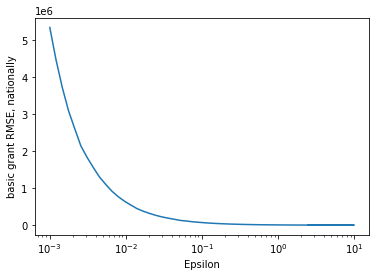

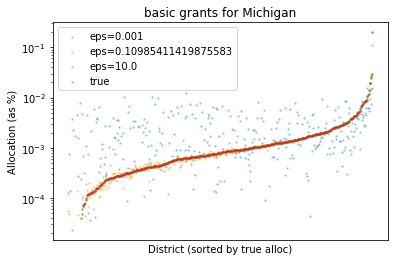

<ipython-input-70-8232b118f5a6>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alloc['err_prop'] = (alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]) - alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"])) * 1e6


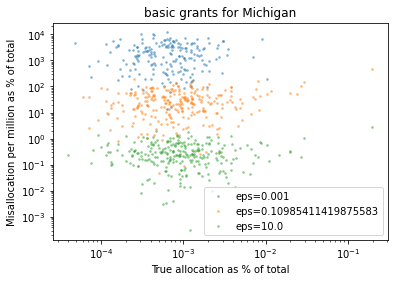

## concentration grants ##
RMSE at eps=2.5: 23802.2655318789
Total misalloc at eps=2.5: 23885090.729607593
Total true alloc: 29421416873.03583


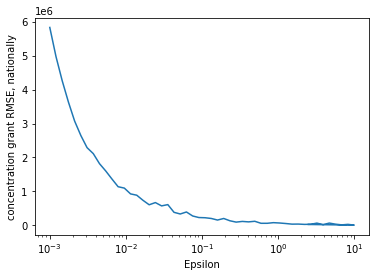

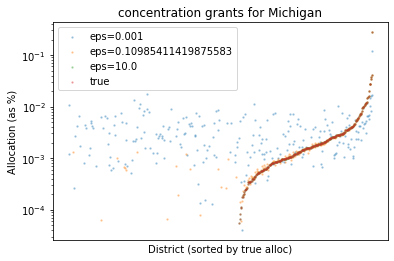

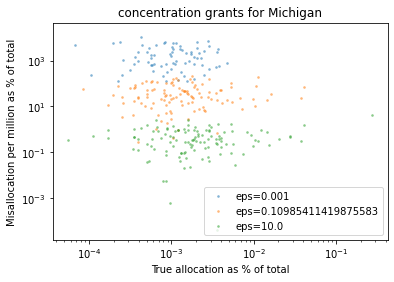

## targeted grants ##
RMSE at eps=2.5: 15955.701215124382
Total misalloc at eps=2.5: 41889378.59896955
Total true alloc: 66729811774.698265


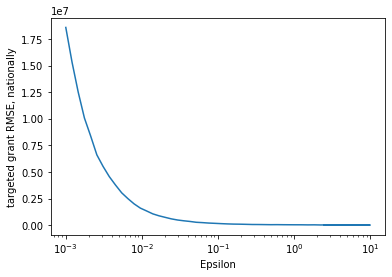

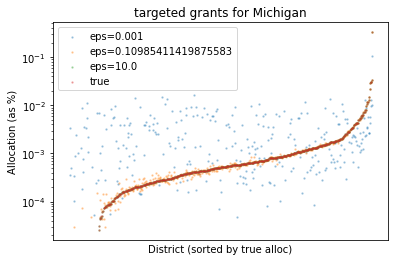

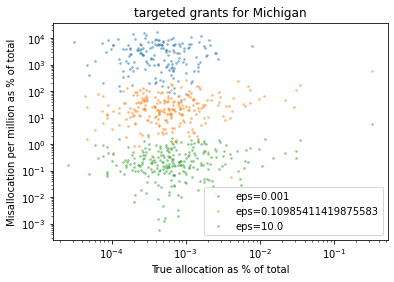

In [70]:
for grant_type in ("basic", "concentration", "targeted"):
    print(f"## {grant_type} grants ##")
    mse = []
    for alloc, e in zip(allocations, eps):
        error = alloc[f"true_grant_{grant_type}"]-alloc[f"est_grant_{grant_type}"]
        mse.append(np.sqrt(sum(error**2)/alloc.shape[0]))
        if (e == 2.5):
            print("RMSE at eps=2.5:", np.sqrt(np.mean(error**2)))
            print("Total misalloc at eps=2.5:", sum(abs(error)))
            print("Total true alloc:", sum(alloc[f"true_grant_{grant_type}"]))

    plt.plot(eps, mse)
    ax = plt.gca()
    ax.set_xscale('log')
    plt.xlabel("Epsilon")
    plt.ylabel(f"{grant_type} grant RMSE, nationally")
    plt.show()
    
    for i in [0, 25, -2]:
        e = eps[i]
        alloc = allocations[i][allocations[i]["State Postal Code"] == "MI"]
        alloc = alloc.sort_values(f"true_grant_{grant_type}")
        plt.scatter(alloc.index.astype('str'), alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]), s=2, alpha=0.3, label=f"eps={e}")
    plt.scatter(alloc.index.astype('str'), alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"]), s=2, alpha=0.3, label="true")
    ax = plt.gca()
    ax.legend()
    ax.axes.xaxis.set_ticks([])
    ax.set_yscale('log')
    plt.xlabel("District (sorted by true alloc)")
    plt.ylabel("Allocation (as %)")
    plt.title(f"{grant_type} grants for Michigan")
    plt.show()
    
    for i in [0, 25, -2]:
        e = eps[i]
        alloc = allocations[i][allocations[i]["State Postal Code"] == "MI"]
        alloc['err_prop'] = (alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]) - alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"])) * 1e6
        plt.scatter(alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"]), alloc.err_prop, s=3, alpha=0.4, label=f"eps={e}")
    ax = plt.gca()
    ax.legend()
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.xlabel("True allocation as % of total")
    plt.ylabel("Misallocation per million as % of total")
    plt.title(f"{grant_type} grants for Michigan")
    plt.show()

### Sanity check: using Abowd's method

Abowd reported a mean squared SPPE of 20 million from 2014-15 data.

In [73]:
grants = funding(saipe, AbowdAllocator, Laplace(saipe, 2.52, 0), get_sppe("../data/sppe18.xlsx"), weighting)
print("Mean Sq. SPPE (2018):", np.mean(grants.adj_sppe**2))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
Mean Sq. SPPE (2018): 26235395.69087739


They also report an RMSE at e=2.52 of 2509 (again, using 2014-15 Common Core data, which I can't replicate) and 1334 at e=4.74 and 63000 at e=0.1. 

In [68]:
# RMSE
error = grants.true_allocation - grants.est_allocation
np.sqrt(np.mean(error**2))

2893.268436870339

In [74]:
grants = funding(saipe, AbowdAllocator, Laplace(saipe, 4.74, 0), get_sppe("../data/sppe18.xlsx"), weighting)
error = grants.true_allocation - grants.est_allocation
np.sqrt(np.mean(error**2))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


1517.1351556922623

In [76]:
grants = funding(saipe, AbowdAllocator, Laplace(saipe, 0.1, 0), get_sppe("../data/sppe18.xlsx"), weighting)
error = grants.true_allocation - grants.est_allocation
np.sqrt(np.mean(error**2))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


70807.21678966618

So we get some small differences due to inflation or due to other differences in data, but roughly the same values. Biggest difference is in SPPE - apparenlty spending has increased since 2014.

### Uncertainty

The simplest approximate measure of uncertainty is given by the Census's median coefficient of varation in the poverty estimates for each district. We can construct a confidence interval for each allocation as follows, ignoring variance due to missing cutoffs (for now) by using the Abowd method.

In [16]:
grants = funding(saipe, AbowdAllocator, Laplace(saipe, 2.52, 0), get_sppe("../data/sppe18.xlsx"), weighting)
grants.head()

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


,State Postal Code,State FIPS Code,Name,true_pop_total,true_children_total,true_children_poverty,median_cv,est_pop_total,est_children_total,est_children_poverty,true_children_eligible,est_children_eligible,sppe,adj_sppe,true_allocation,est_allocation
0,AL,1,Alabaster City School District,34669,6710,649,0.23,34669.691496,6709.893994,649.042059,649,649.042059,9697.0,4168.910429,2.705623e+06,2.705798e+06
1,AL,1,Albertville City School District,22051,4131,957,0.23,22051.245362,4130.972920,955.888237,957,955.888237,9697.0,4168.910429,3.989647e+06,3.985012e+06
2,AL,1,Alexander City City School District,16920,2575,703,0.28,16919.367444,2574.358764,703.120523,703,703.120523,9697.0,4168.910429,2.930744e+06,2.931246e+06
3,AL,1,Andalusia City School District,8842,1465,406,0.35,8843.047741,1464.756734,406.161921,406,406.161921,9697.0,4168.910429,1.692578e+06,1.693253e+06
4,AL,1,Anniston City School District,22043,3065,1057,0.23,22042.863768,3064.987154,1056.906431,1057,1056.906431,9697.0,4168.910429,4.406538e+06,4.406148e+06


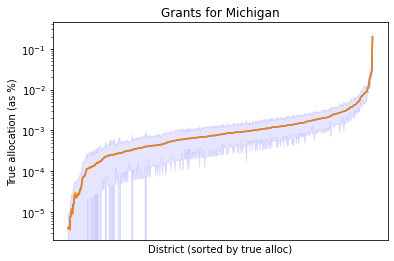

In [35]:
grants = grants[grants["State Postal Code"] == "MI"].sort_values("true_allocation")
x = grants.index.astype('str')
y = grants.true_allocation / sum(grants.true_allocation)
plt.plot(x, y)
ax = plt.gca()
prop_ci = 1.96 * grants.median_cv * y
ax.fill_between(x, (y-prop_ci), (y+prop_ci), color='b', alpha=0.1)

plt.plot(x, grants.est_allocation / sum(grants.est_allocation))

ax.axes.xaxis.set_ticks([])
ax.set_yscale('log')
plt.xlabel("District (sorted by true alloc)")
plt.ylabel("True allocation (as %)")
plt.title(f"Grants for Michigan")
plt.show()

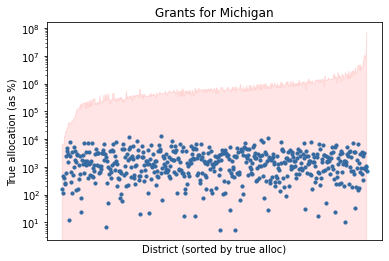

In [49]:
grants = grants[grants["State Postal Code"] == "MI"].sort_values("true_allocation")
x = grants.index.astype('str')
y = np.abs(grants.true_allocation - grants.est_allocation)
plt.scatter(x, y, s=10)

ax = plt.gca()
ci = 1.96 * grants.median_cv * grants.true_allocation
ax.fill_between(x, ci, color='r', alpha=0.1)

ax.axes.xaxis.set_ticks([])
ax.set_yscale('log')
plt.xlabel("District (sorted by true alloc)")
plt.ylabel("True allocation (as %)")
plt.title(f"Grants for Michigan")
plt.show()